### Exercise 10.3

![](./10_3.jpg)

In [17]:
import numpy as np
import sys
from matplotlib import pyplot as plt
import time
import scipy.sparse as sparse
import scipy.sparse.linalg
ROOTDIR = '/home/lochy/Documents/Subject/ucd_geology/Gel298_winter/jupyter_notebooks'
sys.path.append('%s/python_scripts' % ROOTDIR)
from GMesh2d import MESH2D
from GHeatConservationSolver import IMPLICIT_SOLVER
from GMarker import MARKER 

#### Initiate a 2d mesh

This MESH2D class is defined in "python_scripts/GMesh2d.py". 
Here, we use a regular grid of 51 × 31 points. The model size is 1000 × 1500 km2 (i.e. 1 000 000 × 1 500 000 m2). 

In [18]:
# initiate mesh
xsize = 1000000.0 # Model size, m
ysize = 1500000.0
xnum = 41   # Number of nodes
ynum = 61
xs = np.linspace(0.0, xsize, xnum) # construct xs
ys = np.linspace(0.0, ysize, ynum) # construct ys
Mesh2d = MESH2D(xs, ys)

#### Read in the initial temperature

The initial setup corresponds to a background temperature of 1000 K with a rectangular thermal wave (1300 K) in the middle (‘wave’ means sharp perturbation of the temperature field).
Moreover, we assign the thermal parameters accordingly here.

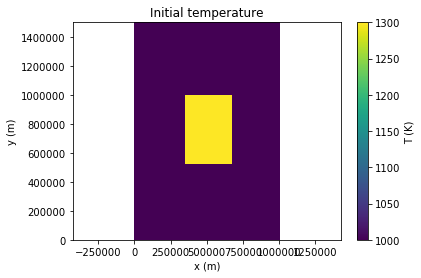

In [19]:
# initial temperature
def rectangular_wave_temperature(x, y, xsize, ysize):
    '''
    temperature profile of a retangular wave in the middle
    '''
    dx = xsize / 3.0
    dy = ysize / 3.0
    if type(x) == float and type(y) == float:
      assert(x >= 0 and x <= xsize and y >= 0 and y <= ysize)
      if x > (xsize - dx) / 2.0 and x < (xsize + dx) / 2.0\
        and y > (ysize - dy) / 2.0 and y < (ysize + dy) / 2.0:
        T = 1300.0
      else:
        T = 1000.0
    elif type(x) == np.ndarray and type(y) == np.ndarray:
      assert(x.shape == y.shape)
      mask = (x > (xsize - dx) / 2.0) & (x < (xsize + dx) / 2.0)\
        & (y > (ysize - dy) / 2.0) & (y < (ysize + dy) / 2.0)
      T = np.ones(x.shape) * 1000.0
      T[mask] = 1300.0
    else:
      raise TypeError("Type of x or y is wrong (either float or numpy.ndarray")
    return T


def rectangular_wave_density(x, y, xsize, ysize):
    '''
    temperature profile of a retangular wave in the middle
    '''
    dx = xsize / 3.0
    dy = ysize / 3.0
    if type(x) == float and type(y) == float:
      assert(x >= 0 and x <= xsize and y >= 0 and y <= ysize)
      if x > (xsize - dx) / 2.0 and x < (xsize + dx) / 2.0\
        and y > (ysize - dy) / 2.0 and y < (ysize + dy) / 2.0:
        rho = 3300.0
      else:
        rho = 3200.0
    elif type(x) == np.ndarray and type(y) == np.ndarray:
      assert(x.shape == y.shape)
      mask = (x > (xsize - dx) / 2.0) & (x < (xsize + dx) / 2.0)\
        & (y > (ysize - dy) / 2.0) & (y < (ysize + dy) / 2.0)
      rho = np.ones(x.shape) * 3200.0
      rho[mask] = 3300.0
    else:
      raise TypeError("Type of x or y is wrong (either float or numpy.ndarray")
    return rho


def rectangular_wave_thermal_capacity(x, y, xsize, ysize):
    '''
    temperature profile of a retangular wave in the middle
    '''
    dx = xsize / 3.0
    dy = ysize / 3.0
    if type(x) == float and type(y) == float:
      assert(x >= 0 and x <= xsize and y >= 0 and y <= ysize)
      if x > (xsize - dx) / 2.0 and x < (xsize + dx) / 2.0\
        and y > (ysize - dy) / 2.0 and y < (ysize + dy) / 2.0:
        cp = 1100.0
      else:
        cp = 1000.0
    elif type(x) == np.ndarray and type(y) == np.ndarray:
      assert(x.shape == y.shape)
      mask = (x > (xsize - dx) / 2.0) & (x < (xsize + dx) / 2.0)\
        & (y > (ysize - dy) / 2.0) & (y < (ysize + dy) / 2.0)
      cp = np.ones(x.shape) * 1000.0
      cp[mask] = 1100.0
    else:
      raise TypeError("Type of x or y is wrong (either float or numpy.ndarray")
    return cp


def rectangular_wave_thermal_conductivity(x, y, xsize, ysize):
    '''
    temperature profile of a retangular wave in the middle
    '''
    dx = xsize / 3.0
    dy = ysize / 3.0
    if type(x) == float and type(y) == float:
      assert(x >= 0 and x <= xsize and y >= 0 and y <= ysize)
      if x > (xsize - dx) / 2.0 and x < (xsize + dx) / 2.0\
        and y > (ysize - dy) / 2.0 and y < (ysize + dy) / 2.0:
        k = 10.0
      else:
        k = 3.0
    elif type(x) == np.ndarray and type(y) == np.ndarray:
      assert(x.shape == y.shape)
      mask = (x > (xsize - dx) / 2.0) & (x < (xsize + dx) / 2.0)\
        & (y > (ysize - dy) / 2.0) & (y < (ysize + dy) / 2.0)
      k = np.ones(x.shape) * 3.0
      k[mask] = 10.0
    else:
      raise TypeError("Type of x or y is wrong (either float or numpy.ndarray")
    return k


class MATERIAL_INDEXES():
    '''
    a wrapper for the material indexes function
    '''
    def __init__(self, xsize, ysize):
        self.xsize = xsize
        self.ysize = ysize

    
    def Rectangular(self, x, y):
        '''
        temperature profile of a retangular wave in the middle
        '''
        xsize = self.xsize
        ysize = self.ysize
        dx = xsize / 3.0
        dy = ysize / 3.0
        if type(x) == float and type(y) == float:
          assert(x >= 0 and x <= xsize and y >= 0 and y <= ysize)
          if x > (xsize - dx) / 2.0 and x < (xsize + dx) / 2.0\
            and y > (ysize - dy) / 2.0 and y < (ysize + dy) / 2.0:
            id = 1
          else:
            id = 0
        elif type(x) == np.ndarray and type(y) == np.ndarray:
          assert(x.shape == y.shape)
          mask = (x > (xsize - dx) / 2.0) & (x < (xsize + dx) / 2.0)\
            & (y > (ysize - dy) / 2.0) & (y < (ysize + dy) / 2.0)
          id = np.ones(x.shape, dtype=np.int8) * 0
          id[mask] = 1
        else:
          raise TypeError("Type of x or y is wrong (either float or numpy.ndarray")
        return id


xxs, yys = np.meshgrid(xs, ys)
Ts_init = rectangular_wave_temperature(xxs, yys, xsize, ysize)
rhos = rectangular_wave_density(xxs, yys, xsize, ysize)
cps = rectangular_wave_thermal_capacity(xxs, yys, xsize, ysize)
thermal_conductivities = rectangular_wave_thermal_conductivity(xxs, yys, xsize, ysize)


# plot
fig, ax = plt.subplots()
h = ax.pcolor(xxs, yys, Ts_init)
ax.set_title('Initial temperature')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.invert_yaxis()
ax.axis('equal')
ax.set_xlim([0.0, xsize])
ax.set_ylim([0.0, ysize])
fig.colorbar(h, ax=ax, label='T (K)')

In [20]:
# Velocity methods
def global_x_velocity(x, y):
    '''
    Global velocity in the x direction
    Inputs:
        x (float): x coordinate
        y (float): y coordinate
    Returns:
        velocity in the x direction
    '''
    return 1e-9


def global_y_velocity(x, y):
    '''
    Global velocity in the x direction
    Inputs:
        x (float): x coordinate
        y (float): y coordinate
    Returns:
        velocity in the y direction
    '''
    return 1e-9

In [21]:
class IMPLICIT_ADVECTION_SOLVER(IMPLICIT_SOLVER):
    
    def assemble(self, dt, vxs, vys, **kwargs):
        '''
        assemble the equations
        Inputs:
            dt (float): increment in time
            vxs: x velocity
            vys: y velocity
            kwargs (dict)
        '''
        # guess is, grid size is 1 km. This won't affect the stability of the solution
        scaling1 = kwargs.get('scaling', 1e-6 / (1000.0)**2.0 * 1000.0)
        assert(vxs.shape == (self.Ny, self.Nx))
        assert(vys.shape == (self.Ny, self.Nx))
        vxs1 = vxs.T.reshape(self.Nx * self.Ny)  # flatten the inputs
        vys1 = vys.T.reshape(self.Nx * self.Ny)
        assert(self.assembled == False)
        self.dt = dt
        Ts = self.Ts.copy()
        xs, ys = self.mesh.get_coordinates()
        I = []  # These are indexed into the "left" matrix L
        J = []  # of the linear function Lx = R
        V = []  # equivalent to L(i, j) = v
        R = []
        i = 0  # incrememnt on i for I indexes
        for jx in range(self.Nx):
            for iy in range(self.Ny):
                k1 = self.global_index(iy, jx - 1)   # index of the point to the left
                k2 = self.global_index(iy - 1, jx)   # index of the point above
                k3 = self.global_index(iy, jx)  # index of this point
                k4 = self.global_index(iy + 1, jx)   # index of the point below
                k5 = self.global_index(iy, jx + 1)   # index of the point to the right
                rho = self.rhos[k3]
                cp = self.cps[k3]
                if iy > 0 and iy < self.Ny-1 and jx > 0 and jx < self.Nx-1:
                    # internal points
                    # derive kappa at these points
                    tc1 = self.thermal_conductivities[k1]
                    tc2 = self.thermal_conductivities[k2]
                    tc3 = self.thermal_conductivities[k3]
                    tc4 = self.thermal_conductivities[k4]
                    tc5 = self.thermal_conductivities[k5]
                    # increment in x and y
                    dx = xs[jx + 1] - xs[jx]
                    dy = ys[iy + 1] - ys[iy]
                    # Diffusion
                    v1 = - (tc1 + tc3) / (2 * dx**2.0) / scaling1
                    v2 = - (tc2 + tc3) / (2 * dy**2.0) / scaling1
                    v3 = (rho * cp / dt + (tc3 + tc5) / (2 * dx**2.0)\
                        + (tc1 + tc3) / (2 * dx**2.0) + (tc3 + tc4) / (2 * dy**2.0)\
                        + (tc2 + tc3) / (2 * dy**2.0)) / scaling1
                    v4 = - (tc3 + tc4) / (2 * dy**2.0) / scaling1
                    v5 = - (tc3 + tc5) / (2 * dx**2.0) / scaling1
                    r = rho * cp * Ts[k3] / dt / scaling1
                    # Advection (todo)
                    velocity_x = vxs1[k3]
                    velocity_y = vys1[k3]
                    if (velocity_x > 0):
                        advect_x = -rho * cp * velocity_x * (self.Ts[k3] - self.Ts[k1]) / dx
                    else:
                        advect_x = -rho * cp * velocity_x * (self.Ts[k5] - self.Ts[k3]) / dx
                    if (velocity_y > 0):
                        advect_y = -rho * cp * velocity_y * (self.Ts[k3] - self.Ts[k2]) / dy
                    else:
                        advect_y = -rho * cp * velocity_y * (self.Ts[k4] - self.Ts[k3]) / dy
                    r += (advect_x + advect_y) / scaling1
                    # manage entry into the matrix
                    I.append(i)  # manage entry of T1
                    J.append(k1)
                    V.append(v1)
                    I.append(i)  # manage entry of T2
                    J.append(k2)
                    V.append(v2)
                    I.append(i)  # manage entry of T3
                    J.append(k3)
                    V.append(v3)
                    I.append(i)  # manage entry of T4
                    J.append(k4)
                    V.append(v4)
                    I.append(i)  # manage entry of T5
                    J.append(k5)
                    V.append(v5)
                    R.append(r)  # entry on the right
                elif iy == 0:
                    # Hereby, the boundaries are handled here. The insulating boudnary conditions
                    # are used here. This is formulated by one point on the boundary and another interal point
                    # next to it.
                    # top boundary
                    I.append(i)
                    J.append(k3)
                    V.append(1)
                    I.append(i)
                    J.append(k4)
                    V.append(-1)
                    R.append(0.0)
                elif iy == self.Ny - 1:
                    # bottom boundary
                    I.append(i)
                    J.append(k2)
                    V.append(1)
                    I.append(i)
                    J.append(k3)
                    V.append(-1)
                    R.append(0.0)
                elif jx == 0:
                    # left boundary
                    I.append(i)
                    J.append(k3)
                    V.append(1)
                    I.append(i)
                    J.append(k5)
                    V.append(-1)
                    R.append(0.0)
                elif jx == self.Nx - 1:
                    # right boundary
                    I.append(i)
                    J.append(k1)
                    V.append(1)
                    I.append(i)
                    J.append(k3)
                    V.append(-1)
                    R.append(0.0)
                else:
                    raise IndexError("Index error found with iy = %d, jx = %d" % (iy, jx))
                i += 1
        assert(i == self.Nx * self.Ny)
        # Finally, assemble the L matrix and the R vector.
        self.L = sparse.csr_matrix((V, (I, J)), shape=(self.Nx * self.Ny, self.Nx * self.Ny))
        self.R = np.array(R)
        self.assembled = True  # set the flags
        self.solved = False


#### Solve the problem

The limit of time step is given by $t_{diff} = \frac{\Delta x^2}{2\kappa}$ and $t_{advect} = \frac{\Delta x}{v_x}$, thus we first output this value below.

In [22]:
year = 365 * 24 * 3600.0
v0 = 1e-9
# use variable thermal parameters
kappa = 3.0 / (3200.0 * 1000.0)  # use the given parameter, derive the smalles kappa manually
dt_diff = (xsize / (xnum-1.0))**2.0 / (2*kappa)
dt_advect = (xsize / (xnum-1.0)) / v0
dt_m = min(dt_diff, dt_advect)
print("Limit on time step from diffusion: %.4e year, from advection: %.4e year" % (dt_diff / year, dt_advect / year))
print("Limit on time step: %.4e year" % (dt_m / year))

Limit on time step from diffusion: 1.0570e+07 year, from advection: 7.9274e+05 year
Limit on time step: 7.9274e+05 year


With this estimation, we first test a scenario where the time increment is choosen as $0.6 t_m$.

Here we assign the vertical and horizontal velocity.

In [23]:
# load the marker
# MaterialIndexes = MATERIAL_INDEXES(xsize, ysize)
# Marker = MARKER(Mesh2d, 100, 150, material_indexes_method=MaterialIndexes.Rectangular)
# Marker.set_velocity_method(global_x_velocity, global_y_velocity)
vxs = np.ones(xxs.shape) * v0
vys = np.ones(yys.shape) * v0
# vxs = np.ones(xxs.shape) * 1  # test big velocities
# vys = np.ones(yys.shape) * 1

Temperature solver: 1.0289e-02 s to solver
Temperature solver: 9.0115e-03 s to solver
Temperature solver: 8.3179e-03 s to solver
Temperature solver: 9.0833e-03 s to solver
Temperature solver: 8.7106e-03 s to solver
Temperature solver: 9.3813e-03 s to solver
Temperature solver: 8.8537e-03 s to solver
Temperature solver: 8.5819e-03 s to solver
Temperature solver: 9.0721e-03 s to solver
Temperature solver: 8.6277e-03 s to solver
Temperature solver: 8.9564e-03 s to solver
Temperature solver: 1.1611e-02 s to solver
Temperature solver: 8.6572e-03 s to solver
Temperature solver: 1.1415e-02 s to solver
Temperature solver: 9.1455e-03 s to solver
Temperature solver: 8.9457e-03 s to solver
Temperature solver: 8.8358e-03 s to solver
Temperature solver: 8.5807e-03 s to solver
Temperature solver: 1.0635e-02 s to solver
Temperature solver: 8.7781e-03 s to solver


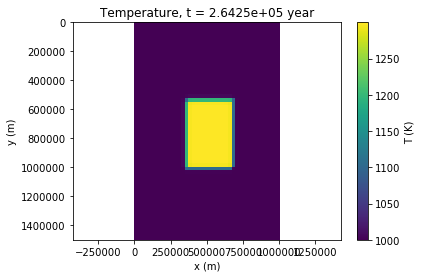

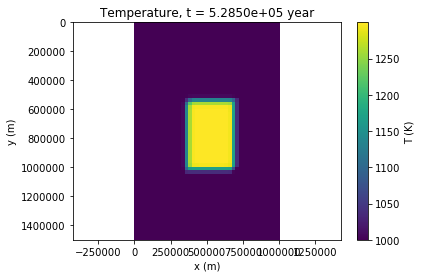

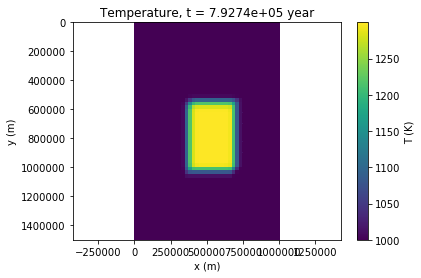

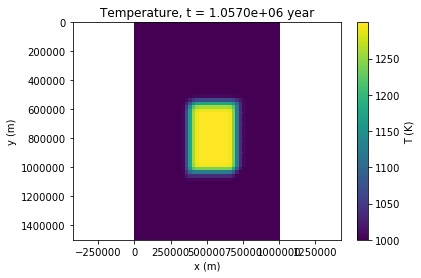

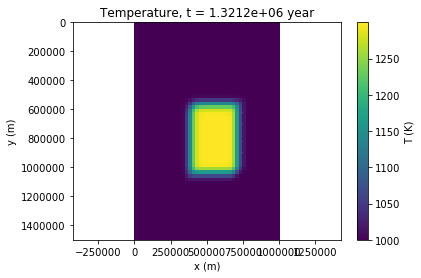

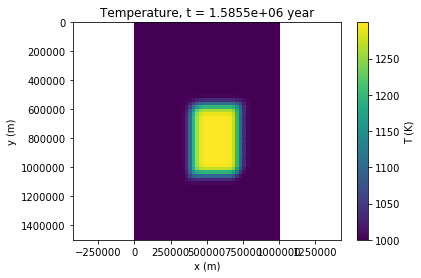

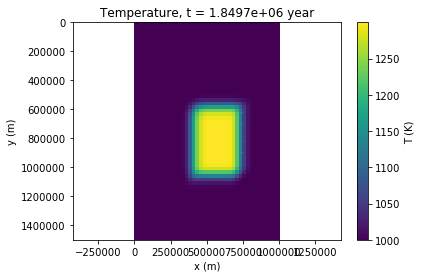

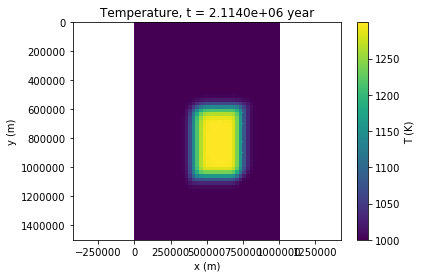

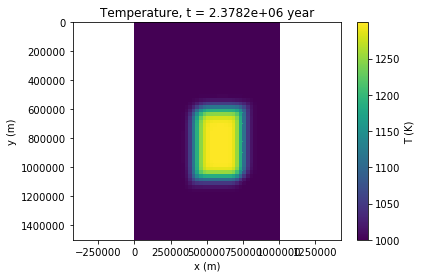

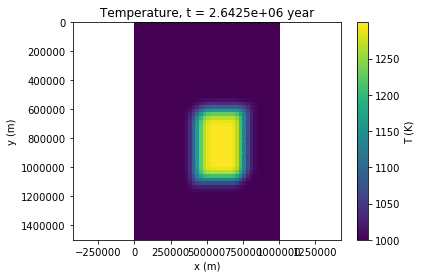

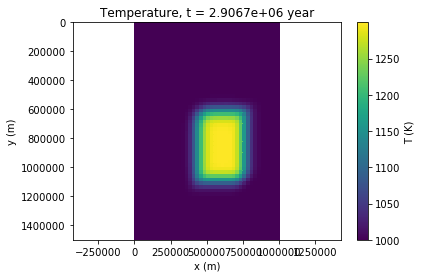

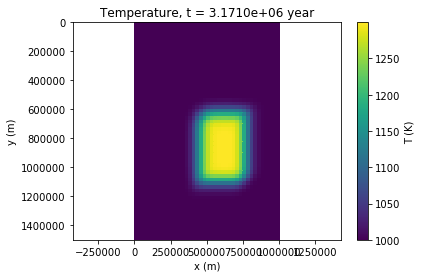

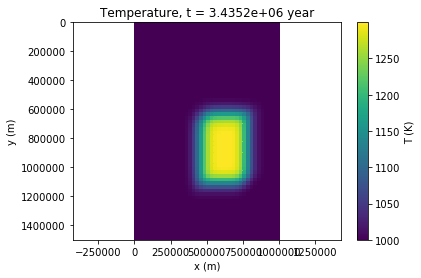

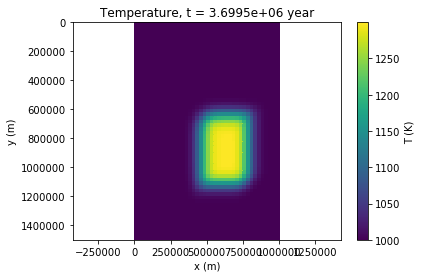

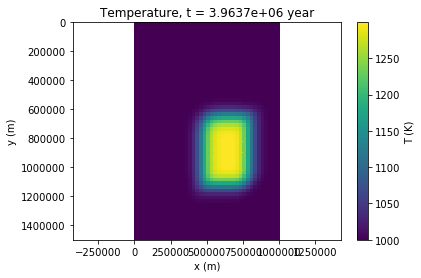

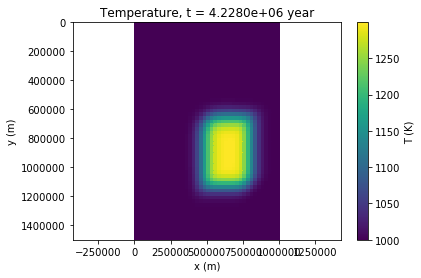

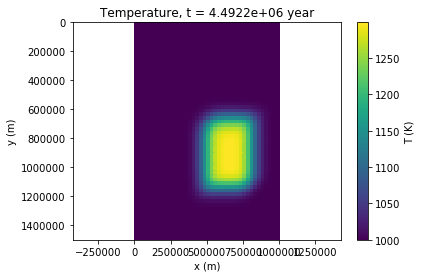

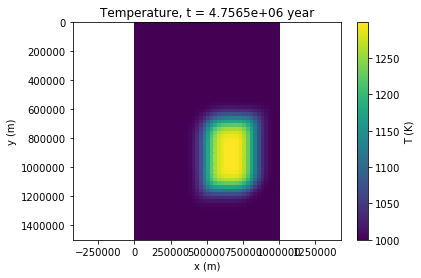

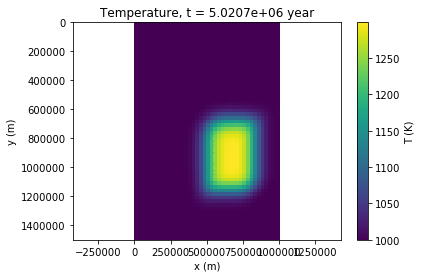

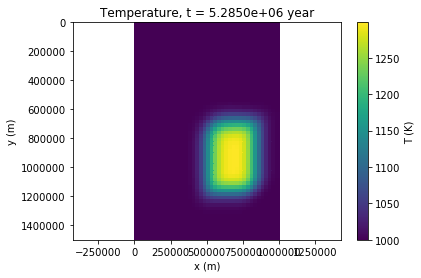

In [24]:
scaling1 = 1e-6 / (xsize/xnum)**2.0 * 1000.0  # scaling factor, kappa / dx^2.0 * T
dt = dt_m / 3.0  # what Geyra used in his script.
# dt = 1.0  # debug: with this, the temperature profile should be the initial profile
total_step = 20
# initiate solver
HCSolver = IMPLICIT_ADVECTION_SOLVER(Mesh2d)
HCSolver.initial_temperature(Ts_init)  # use the rectangular perturbation as the initial temperature
HCSolver.thermal_profile(rhos, cps, thermal_conductivities)  # load the thermal parameters as well
dt_old = 0.0
for step in range(total_step):
    # assemble and solve
    HCSolver.assemble(dt, vxs, vys, scaling=scaling1)
    HCSolver.solve()
    dt_old = dt
    # export and plot
    xxs, yys, Ts = HCSolver.export()
    t = HCSolver.get_time()
    fig, ax = plt.subplots()
    h = ax.pcolor(xxs, yys, Ts)
    ax.set_title('Temperature, t = %.4e year' % (t/year))
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_xlim([0.0, xsize])
    ax.set_ylim([0.0, ysize])
    ax.axis('equal')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='T (K)')